### YOLOv1

Yolo là một mô hình mạng CNN cho việc phát hiện, nhận dạng, phân loại đối tượng. Yolo được tạo ra từ việc kết hợp giữa các convolutional layers và connected layers.Trong đóp các convolutional layers sẽ trích xuất ra các feature của ảnh, còn full-connected layers sẽ dự đoán ra xác suất đó và tọa độ của đối tượng.

Kiến trúc mạng được lấy ý tưởng từ GoogleNet, gồm 24 Convolutional layers và 2 fully connected layers. Thay vì dùng inception module, YOLO sử dụng các convolutional layers với kernel size 3x3.

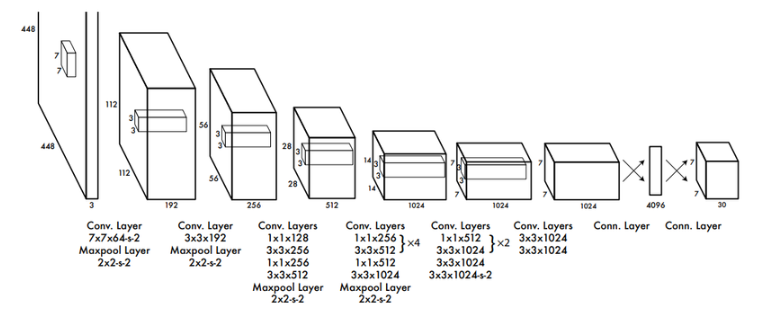

Đầu vào của mô hình là một ảnh, mô hình sẽ nhận dạng ảnh đó có đối tượng nào hay không, sau đó sẽ xác định tọa độ của đối tượng trong bức ảnh. ẢNh đầu vào được chia thành thành $S * S$

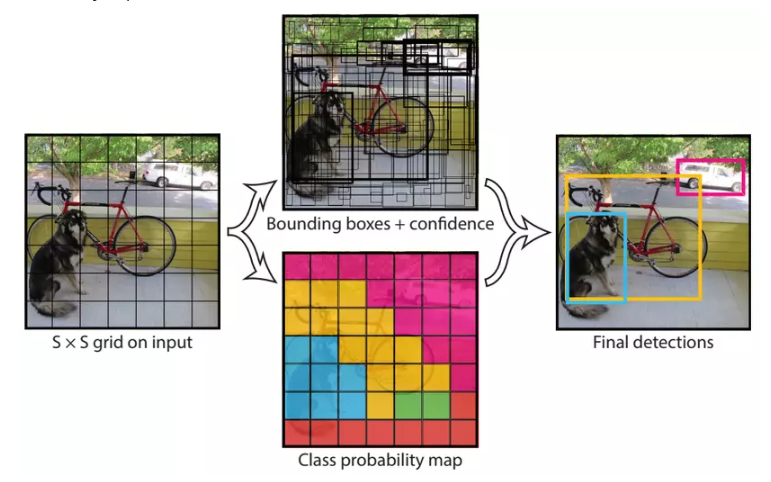

Với Input là 1 ảnh, đầu ra mô hình là một ma trận 3 chiều có kích thước $S * S * (N * 5 + M)$, trong đó:
- S: số lượng ô vuông chia ảnh
- N: số lượng class cần phân loại
- M: số lượng bounding box mô hình dự đoán

VD: Ảnh trên chia thành $7 * 7$ ô vuông, mô hình dự đoán 2 bounding box và 3 class, kích thước đầu ra của mô hình sẽ là $7 * 7 * (2 * 5 + 3) = 147$, tức là mỗi ô sẽ có 13 tham số, kết quả trả về cho kết quả là $7 * 7 * 2 = 98$

Các bounding box sẽ gồm 5 thành phần là: $x, y, w, h, confidence$, trong đó:
- x, y: tọa độ của bounding box
- w, h: chiều rộng và chiều cao của bounding box
- confidence: xác suất của bounding box chứa đối tượng

confidence được định nghĩa là P(Object) * IOU, trong đó:
- P(Object): xác suất của bounding box chứa đối tượng
- IOU: Intersection over Union, tỉ lệ giữa diện tích giao và diện tích hợp của 2 bounding box

Với hình ảnh trên như ta tính mỗi ô sẽ có 13 tham số, ta có thể hiểu đơn giản như sau tham số thứ 1 sẽ chỉ ra ô đó có chứa đối tượng nào hay không P(Object), tham số 2, 3, 4, 5 sẽ trả về x, y , w, h của BOX 1, tham số 6, 7, 8, 9 sẽ trả về x, y, w, h của BOX 2, tham số 10, 11, 12 sẽ trả về xác suất của 3 class, tham số 13 sẽ trả về xác suất của bounding box chứa đối tượng.

**Lưu ý**: Tâm của bounding box của ô nào, thì ô đó sẽ có đối tượng, cho dù có nằm ở các ô khác thì cũng trả về 0. Vì vậy 1 ô có thể chữa nhiều tâm của bounding box. Đó là hạn chế của Yolov1, vì thế ta phải tăng số lượng ô chia trong một ảnh nhưng nó cũng làm ảnh hưởng đến mô hình

### IOU (Intersection over Union)

Ở trên ta có đề cập về confidence, đó là xác suất của bounding box chứa đối tượng. Để tính confidence ta cần phải tính IOU, tỉ lệ giữa diện tích giao và diện tích hợp của 2 bounding box.

IOU là hàm đánh giá độ chính xác của object trên ảnh, nó được tính bằng công thức:

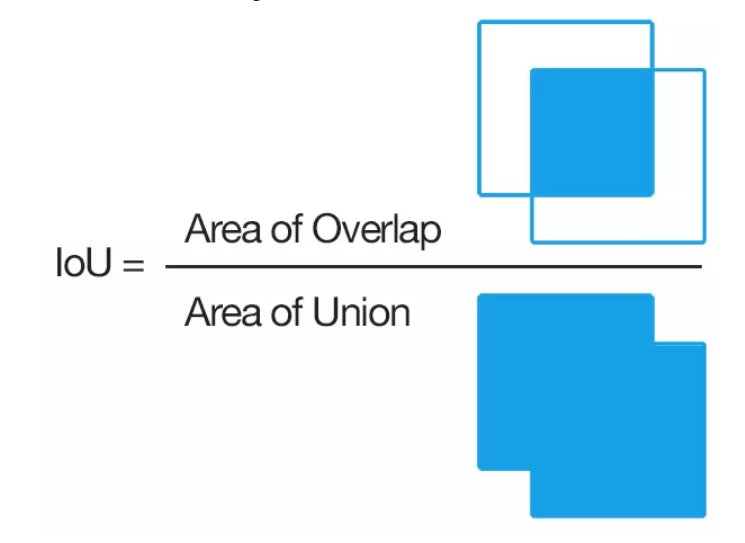

Trong đó:
- Area overlap: diện tích giao của 2 bounding box
- Area union: diện tích hợp của 2 bounding box

Ngoài ra nó sẽ bao gồm việc ta xác định vị trí cạnh lớn nhất và nhỏ nhất của 2 bounding box, nếu không có giao nhau thì IOU = 0, nếu có giao nhau thì IOU sẽ nằm trong khoảng [0, 1]

VD: ta cần dựa vào:
- Ground-truth bounding box: (10, 10, 40, 40)
- Predicted bounding box: (20, 20, 50, 50)

Ta sẽ chọn ra tọa độ lớn nhất bên trái và nhỏ nhất bên phải của 2 bounding box, tương tự với tọa độ lớn nhất bên trên và nhỏ nhất bên dưới của 2 bounding box, sau đó ta sẽ tính diện tích giao và diện tích hợp của 2 bounding box, từ đó ta sẽ tính được IOU

- Tọa độ lớn nhất bên trái:
x1_max = max(x1_gt, x1_pred) = 20
- Tọa độ nhỏ nhất bên phải:
x2_min = min(x2_gt, x2_pred) = 40
- Tọa độ lớn nhất bên trên:
y1_max = max(y1_gt, y1_pred) = 20
- Tọa độ nhỏ nhất bên dưới:
y2_min = min(y2_gt, y2_pred) = 40

### Non-Max suppression

Non-Max Suppression (NMS) là một kỹ thuật được sử dụng trong các mô hình phát hiện đối tượng để loại bỏ các hộp giới hạn dự đoán dư thừa hoặc không chính xác. NMS hoạt động dựa trên nguyên tắc chỉ giữ lại những hộp giới hạn có độ tin cậy cao và loại bỏ những hộp giới hạn có độ tin cậy thấp hoặc chồng lấn với những hộp giới hạn khác.

Cách dùng:
- Sắp xếp lại các bounding box theo thứ tự giảm dần của confidence
- Chọn bounding box có confidence cao nhất làm bounding box chính
- Tính IOU của bounding box còn lại với bounding box chính, nếu IOU > threshold thì loại bỏ bounding box đó
- Lặp lại bước 2 và 3 cho đến khi không còn bounding box nào

### Loss function

Các hàm error function được sử dụng trong YOLOv1:
- Classification error: sử dụng hàm softmax để tính xác suất của class, sau đó sử dụng hàm cross-entropy để tính lỗi
- Localization error: sử dụng hàm mean square error để tính lỗi giữa tọa độ thực và tọa độ dự đoán
- Confidence error: sử dụng hàm mean square error để tính lỗi giữa confidence thực và confidence dự đoán

#### Classification error

Hàm này chỉ tính trên những grid có xuất hiện object,nó có công thức như sau:

$$L_{cls} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{obj} \sum_{c \in classes} 1_{ij}^{obj} (p_{ij}(c) - \hat{p}_{ij}(c))^2$$

Với:
- $L_{cls}$: lỗi phân loại
- $S^2$: số lượng ô vuông chia ảnh
- $B$: số lượng bounding box mô hình dự đoán
- $1_{ij}^{obj}$: chỉ số của ô chứa đối tượng
- $p_{ij}(c)$: xác suất của class c
- $\hat{p}_{ij}(c)$: xác suất của class c dự đoán

#### Localization error

Hàm dùng để tính giá trị lỗi cho bounding box dự đoán, ta không nên tính trức tiệp với kích thước ảnh cũ, mà nên chuẩn hóa về kích thước ảnh mới.

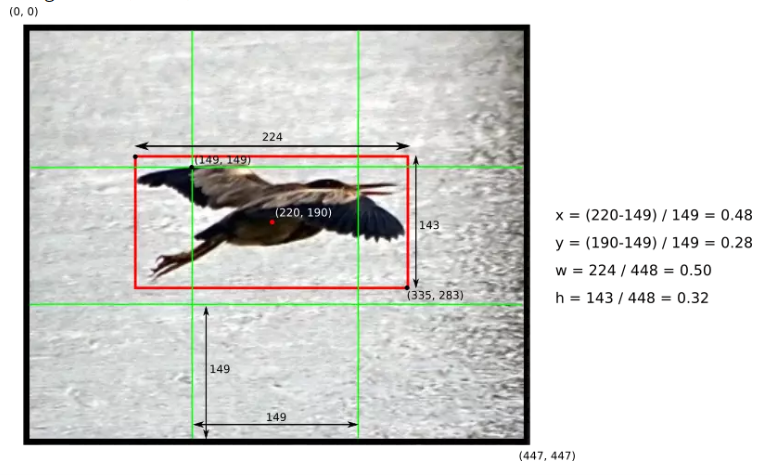

Giá trị hàm Localization loss được tính trên tổng giá trị lỗi dự đoán toạ độ tâm (x, y) và (w, h) của predicted bounding box với grouth-truth bounding box. Tại mỗi ô có chưa object, ta chọn 1 boundary box có IOU (Intersect over union) tốt nhất, rồi sau đó tính độ lỗi theo các boundary box này.

Công thức dự đoán tọa độ tâm (x, y) của predict bounding box và tọa độ trung tâm của ground-truth bounding box như sau:

$$\lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{obj} [(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2]$$

Giá trị lỗi của tọa độ (w, h) của predict so với ground-truth là:

$$\lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{obj} [(\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2]$$

Với ví dụ trên thì $S = 7$, $B = 2$, còn $\lambda_{coord}$ là trọng số thành phần trong paper gốc tác giả lấy giá trị là 5

#### Confidence error

Là lỗi của confidence của predict so với ground-truth, nó tính trên cả ô chứa object và không chứa object, công thức như sau:

$$L_{conf} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{obj} (C_i - \hat{C}_i)^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} 1_{ij}^{noobj} (C_i - \hat{C}_i)^2$$

Với ví dụ trên thì $S = 7$, $B = 2$, còn $\lambda_{noobject}$ là trọng số thành phần trong paper gốc tác giả lấy giá trị là 0.5. Đối với các hộp j của ô thứ i nếu xuất hiệu object thì $C_i = 1$ và ngược lại

#### Total loss

Tổng lỗi của mô hình sẽ là tổng của 3 lỗi trên, công thức như sau:

$$ L_{total} = L_{cls} + L_{loc} + L_{conf}$$

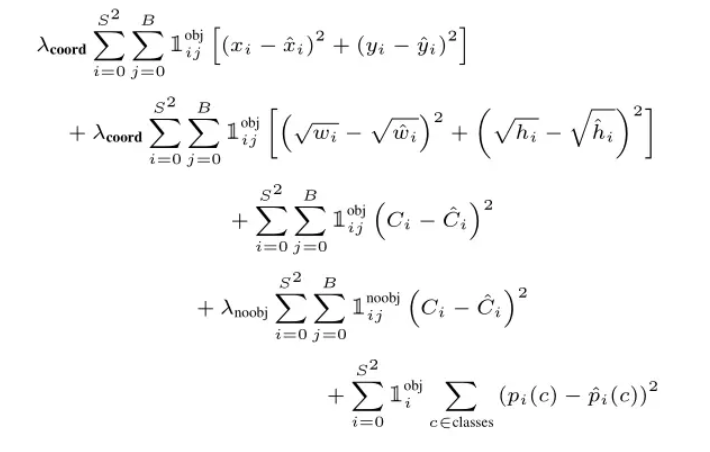

### Architecture

YOLO là một mô hình mạng CNN thông thường gồm các convolutional layers kết hợp maxpooling layers và cuối cùng là 2 lớp fully connected layers, với hàm kích hoạt cho layer cuối cùng là một linear activation function và tất cả các layers khác sẽ sử dụng leaky RELU

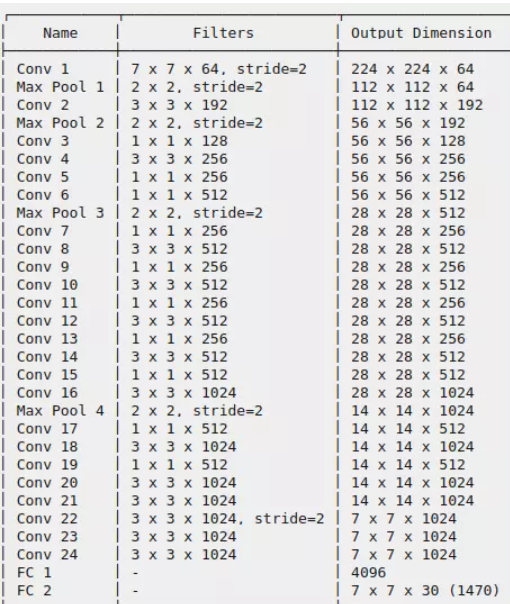